## This is a notebook to train an LSTM
The LSTM in the project is used to predict future volatility because:
- Black-Scholes and Monte Carlo need volatility as a core input
- Volatility is harder to model with classical methods (good use case for ML)
- LSTM excels at modeling sequential patterns in non-stationary data like realized volatility

In [ ]:
# imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import yfinance as yf


### 1. Data Loading and Preprocessing

We download historical stock data and then calculate daily log returns. To predict volatility, we'll compute **realized volatility** over a rolling window (e.g., 5 days) from these log returns. This realized volatility will be our target variable. Using realized volatility directly is often more effective than predicting raw returns and then inferring volatility.

In [21]:
# Download historical stock price data (e.g., AAPL)
ticker = "AAPL"
start_date = "2010-01-01" # Longer history might be beneficial
end_date = "2024-12-31"
raw_data = yf.download(ticker, start=start_date, end=end_date)
raw_data = raw_data[['Close']].dropna()

# Calculate Log Returns
raw_data['LogReturn'] = np.log(raw_data['Close'] / raw_data['Close'].shift(1))
raw_data.dropna(inplace=True)

# Calculate Realized Volatility (e.g., 5-day rolling standard deviation of log returns)
volatility_window = 5 
raw_data['RealizedVolatility'] = raw_data['LogReturn'].rolling(window=volatility_window).std() * np.sqrt(252) # Annualized
raw_data.dropna(inplace=True)

df_pandas = raw_data[['RealizedVolatility']].copy()

# Scale the Realized Volatility
scaler = StandardScaler()
df_pandas["VolatilityScaled"] = scaler.fit_transform(df_pandas[["RealizedVolatility"]])

display(df_pandas.head())
display(df_pandas.describe())

[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Price,RealizedVolatility,VolatilityScaled
Ticker,,
Date,,
2010-01-11,0.141603,-0.646123
2010-01-12,0.140790,-0.651555
2010-01-13,0.168835,-0.464358
2010-01-14,0.173397,-0.433911
2010-01-15,0.187103,-0.342422


[*********************100%***********************]  1 of 1 completed



Price,RealizedVolatility,VolatilityScaled
Ticker,,
Date,,
2010-01-11,0.141603,-0.646123
2010-01-12,0.140790,-0.651555
2010-01-13,0.168835,-0.464358
2010-01-14,0.173397,-0.433911
2010-01-15,0.187103,-0.342422


Price,RealizedVolatility,VolatilityScaled
Ticker,,
count,3768.000000,3.768000e+03
mean,0.238404,3.017167e-17
std,0.149838,1.000133e+00
min,0.011921,-1.511719e+00
25%,0.138301,-6.681664e-01
50%,0.201650,-2.453289e-01
75%,0.296086,3.850138e-01
max,1.718667,9.880399e+00


### 2. Create Sequences for LSTM
We transform the time series data into sequences (input `X`) and corresponding target values (`y`). The `window_size` determines how many past observations are used to predict the next one.

In [22]:
# Create sliding windows
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 20 # Number of past days' volatility to use for prediction
X, y = create_sequences(df_pandas["VolatilityScaled"].values, window_size)


In [23]:
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add feature dimension
y_tensor = torch.tensor(y, dtype=torch.float32)

# Train/test split
split_ratio = 0.8
split_idx = int(len(X_tensor) * split_ratio)
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([2998, 20, 1]), y_train shape: torch.Size([2998])
X_test shape: torch.Size([750, 20, 1]), y_test shape: torch.Size([750])


### 3. DataLoader Setup

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 4. LSTM Model Definition
We define an LSTM model. To improve generalization and reduce overfitting, a `Dropout` layer is added after the LSTM layers. Dropout randomly sets a fraction of input units to 0 at each update during training time.

In [25]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout_prob=0.2): # Added dropout_prob
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        # Dropout in LSTM is applied between layers if num_layers > 1
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We take the output of the last time step
        out = lstm_out[:, -1, :]
        out = self.dropout(out) # Apply dropout before the final linear layer
        out = self.linear(out)
        return out.squeeze()

model = LSTMModel(hidden_size=50, num_layers=2, dropout_prob=0.25) # Example: adjusted hidden_size and dropout
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 5. Training the Model
The model is trained for a specified number of epochs. 
**Further improvements for training:**
- **Longer Training / More Epochs**: The current `num_epochs` might be too low for the model to converge. Increase it and monitor the loss. 
- **Learning Rate Schedulers**: Consider using a learning rate scheduler (e.g., `torch.optim.lr_scheduler.StepLR` or `ReduceLROnPlateau`) to adjust the learning rate during training, which can help in finding a better minimum.
- **Early Stopping**: Implement early stopping to monitor validation loss and stop training if it doesn't improve for a certain number of epochs. This prevents overfitting and saves training time. You'd typically split your training data further into training and validation sets for this.

In [ ]:
# Training loop
num_epochs = 100
train_losses = []
test_losses = [] # To monitor test loss during training

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_epoch_train_loss)
    
    # Evaluate on test set at the end of each epoch
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for xb_test, yb_test in test_loader:
            pred_test = model(xb_test)
            loss_test = criterion(pred_test, yb_test)
            epoch_test_loss += loss_test.item()
    avg_epoch_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_epoch_test_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_epoch_train_loss:.4f}, Test Loss: {avg_epoch_test_loss:.4f}")


Epoch 10/100, Train Loss: 0.2830, Test Loss: 0.2015
Epoch 20/100, Train Loss: 0.2403, Test Loss: 0.1937
Epoch 20/100, Train Loss: 0.2403, Test Loss: 0.1937
Epoch 30/100, Train Loss: 0.2341, Test Loss: 0.1922
Epoch 30/100, Train Loss: 0.2341, Test Loss: 0.1922
Epoch 40/100, Train Loss: 0.2207, Test Loss: 0.1833
Epoch 40/100, Train Loss: 0.2207, Test Loss: 0.1833
Epoch 50/100, Train Loss: 0.2166, Test Loss: 0.1810
Epoch 50/100, Train Loss: 0.2166, Test Loss: 0.1810
Epoch 60/100, Train Loss: 0.2143, Test Loss: 0.1828
Epoch 60/100, Train Loss: 0.2143, Test Loss: 0.1828
Epoch 70/100, Train Loss: 0.2011, Test Loss: 0.1808
Epoch 70/100, Train Loss: 0.2011, Test Loss: 0.1808
Epoch 80/100, Train Loss: 0.1988, Test Loss: 0.1769
Epoch 80/100, Train Loss: 0.1988, Test Loss: 0.1769
Epoch 90/100, Train Loss: 0.1997, Test Loss: 0.1736
Epoch 90/100, Train Loss: 0.1997, Test Loss: 0.1736
Epoch 100/100, Train Loss: 0.1936, Test Loss: 0.1708
Epoch 100/100, Train Loss: 0.1936, Test Loss: 0.1708


| Epoch | Train Loss ↓ | Test Loss ↓ | Gap    |
| ----- | ------------ | ----------- | ------ |
| 10    | 0.2830       | 0.2015      | 0.0815 |
| 50    | 0.2166       | 0.1810      | 0.0356 |
| 100   | 0.1936       | 0.1708      | 0.0228 |


The model is generalizing well and shows no signs of memorization

Possibly underfitting slightly, meaning you might even benefit from a slightly deeper model or more training time

### Plot Training and Test Loss

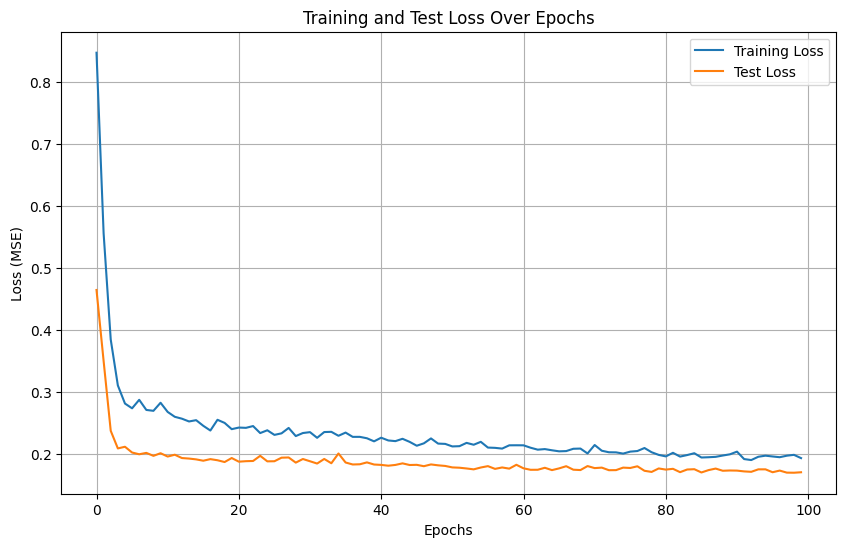

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### 6. Evaluation
After training, evaluate the model on the test set.
**Hyperparameter Tuning:**
The current hyperparameters (window size, hidden units, layers, learning rate, batch size, dropout rate) are just examples. For optimal performance, these should be tuned systematically using techniques like:
- Grid Search
- Random Search
- Bayesian Optimization (e.g., using libraries like Optuna or Hyperopt)
This involves training the model multiple times with different hyperparameter combinations and selecting the one that performs best on a validation set.

Evaluation on SCALED data:
Mean Squared Error (Scaled): 0.1736
Mean Absolute Error (Scaled): 0.2697
Evaluation on ACTUAL (inverse-transformed) data:
Mean Squared Error (Actual): 0.0039
Mean Absolute Error (Actual): 0.0404


,True Volatility (Scaled),Predicted Volatility (Scaled),True Volatility (Actual),Predicted Volatility (Actual)
0,0.411598,-0.074107,0.300069,0.227302
1,0.491166,0.369000,0.311990,0.293687
2,0.523589,0.448926,0.316847,0.305661
3,-0.338536,0.507063,0.187685,0.314371
4,0.207342,-0.218813,0.269468,0.205622


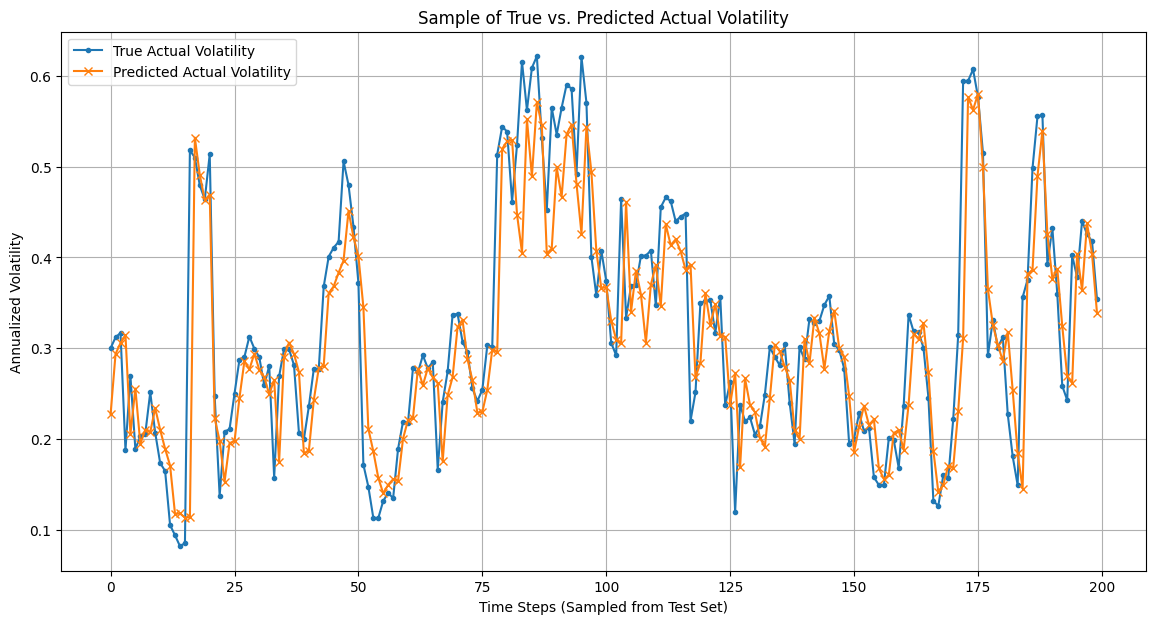

In [32]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test).numpy()
    true_vals_scaled = y_test.numpy()

# Inverse transform to get actual volatility values (if needed for interpretation)
# Ensure scaler was fit on a 2D array, so reshape predictions and true_vals
predictions_actual = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
true_vals_actual = scaler.inverse_transform(true_vals_scaled.reshape(-1, 1)).flatten()

mse_scaled = mean_squared_error(true_vals_scaled, predictions_scaled)
mae_scaled = mean_absolute_error(true_vals_scaled, predictions_scaled)
mse_actual = mean_squared_error(true_vals_actual, predictions_actual)
mae_actual = mean_absolute_error(true_vals_actual, predictions_actual)

results_df = pd.DataFrame({
    "True Volatility (Scaled)": true_vals_scaled,
    "Predicted Volatility (Scaled)": predictions_scaled,
    "True Volatility (Actual)": true_vals_actual,
    "Predicted Volatility (Actual)": predictions_actual
})

print("Evaluation on SCALED data:")
print(f"Mean Squared Error (Scaled): {mse_scaled:.4f}")
print(f"Mean Absolute Error (Scaled): {mae_scaled:.4f}")

print("Evaluation on ACTUAL (inverse-transformed) data:")
print(f"Mean Squared Error (Actual): {mse_actual:.4f}")
print(f"Mean Absolute Error (Actual): {mae_actual:.4f}")

display(results_df.head())

# Plotting a sample of predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(true_vals_actual[:200], label='True Actual Volatility', marker='.')
plt.plot(predictions_actual[:200], label='Predicted Actual Volatility', marker='x')
plt.title('Sample of True vs. Predicted Actual Volatility')
plt.xlabel('Time Steps (Sampled from Test Set)')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.show()

### 7. Saving the Model (Optional)
If you're satisfied with the model, you can save its state_dict.

In [30]:
torch.save(model.state_dict(), 'lstm_volatility_model.pth')
# To load: model.load_state_dict(torch.load('lstm_volatility_model.pth'))